## Simulation Approach

- 1_000_000 rounds for statistical significane
- Fixed 95% RTP Target
- House edge of 5% fixed

## Imports

In [1]:
import json
import random
import pandas as pd
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt

## Implementation

In [2]:
# Import json parsheet DICE-10K
with open('parsheet-10k.json') as f:
    parsheet = json.load(f)

In [3]:
# game settings
game_id = parsheet['id']
target_rtp = parsheet['target_rtp'] * 100  # in parsheet value is in decimal
house_edge = (100 - target_rtp)
bet = parsheet['bets'][5]

In [4]:
game_id, target_rtp, house_edge, bet

('DICE-10K', 95.0, 5.0, 1)

### Formula for calculating multipliers
---
- house_edge: 0.05
- rtp: 0.95

---
#### Under
```python
x = 71.39  # under
multiplier = ((1 - house_edge)*100) / (x)
round(multiplier,2)
```
> 1.33

#### Over
```python
x = 95-71.39  # over
multiplier = ((1 - house_edge)*100) / (x)
round(multiplier,2)
```
> 4.02

### Final Generalised Formula

Formula: 

- If b = 0, i.e. under (blue) \
    $ multiplier(X,rtp)=  \frac{100}{X} \times \frac{rtp}{100} $

- If b = 1, i.e. over (purple) \
    $ multiplier(X,rtp)=  \frac{100}{100 - (X + house\_edge)} \times \frac{rtp}{100} $


`X`: user selected number
`rtp`: given in parsheet (e.g. 95)
`house_edge`: given in parsheet (e.g. 5)

In [5]:
def multiplier(X, a, b):
    """
    X: user-selected value (e.g. 47.5)
    a: target RTP (e.g. 95)
    b: bet type: 0 = under, 1 = over

    Returns:
        Adjusted multiplier, accounting for house edge (black zone)
    """
    if b == 0:  # under (blue)
        return round((100 / X) * (a / 100), 2)
    elif b == 1:  # over (purple)
        return round((100 / (100 - (X + 5))) * (a / 100), 2)
    else:
        raise ValueError("Invalid bet type: use 0 for under or 1 for over.")

out = multiplier(35.29, target_rtp, 0)
out

2.69

In [6]:
print(f"Multiplier when user chosen under: {multiplier(54.69, 95, 0)}")

Multiplier when user chosen under: 1.74


In [7]:
print(f"Multiplier when user chosen over: {multiplier(54.69, 95, 1)}")

Multiplier when user chosen over: 2.36


## Simulation

In [8]:
def single_run(bet, X, target_rtp, bet_type, n_rounds=1):
    """
    Simulate single run
    """
    mul = multiplier(X, target_rtp, bet_type)
    
    return mul

blue, purple = single_run(bet, 28.28, target_rtp, 0), single_run(bet, 28.28, target_rtp, 1)
blue, purple

(3.36, 1.42)

In [9]:
def simulation(bet, X, target_rtp, bet_type, n_rounds=1_000_000):
    results = []
    total_payout = 0.0
    total_bet = 0.0

    for _ in tqdm(range(n_rounds)):
        rand = round(np.random.uniform(0, 100), 2)
        mul = multiplier(X, target_rtp, bet_type)

        win = False
        if bet_type == 0:  # under (blue)
            win = rand < X
        elif bet_type == 1:  # over (purple)
            win = rand >= X + 5

        payout = bet * mul if win else 0

        results.append({'bet': bet,
                        'bet_type': bet_type,
                        'X': X,
                        'rand': rand,
                        'mul': mul,
                        'payout': payout})
        total_bet += bet
        total_payout += payout

    df = pd.DataFrame(results)
    print(total_bet)
    print(total_payout)
    return df, total_bet, total_payout

result_u, total_bet_u, total_payout_u = simulation(bet, 28.28, 95, 0, n_rounds=1_000_000)
print(f"Final RTP: {total_payout_u/total_bet_u * 100}%")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 630381.43it/s]


1000000.0
951941.759996608
Final RTP: 95.1941759996608%


In [10]:
result_o, total_bet_o, total_payout_o = simulation(bet, 28.28, 95, 1, n_rounds=1_000_000)
print(f"Final RTP: {total_payout_o/total_bet_o * 100}%")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:01<00:00, 596078.67it/s]


1000000.0
946554.9600104957
Final RTP: 94.65549600104957%


In [29]:
a, b = result_u['payout'].unique()
a, b = float(a), float(b)
no_mul, mul = result_u['payout'].unique()
no_mul, mul = float(no_mul), float(mul)

(0.0, 3.36)

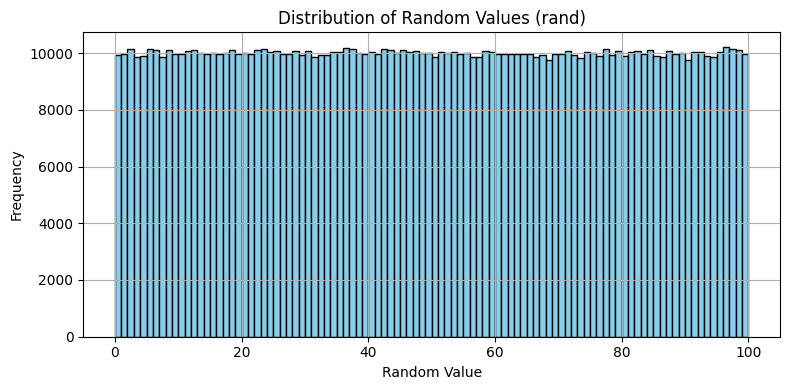

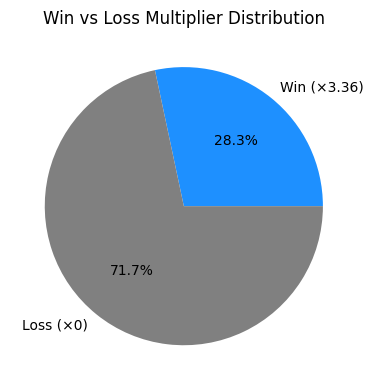

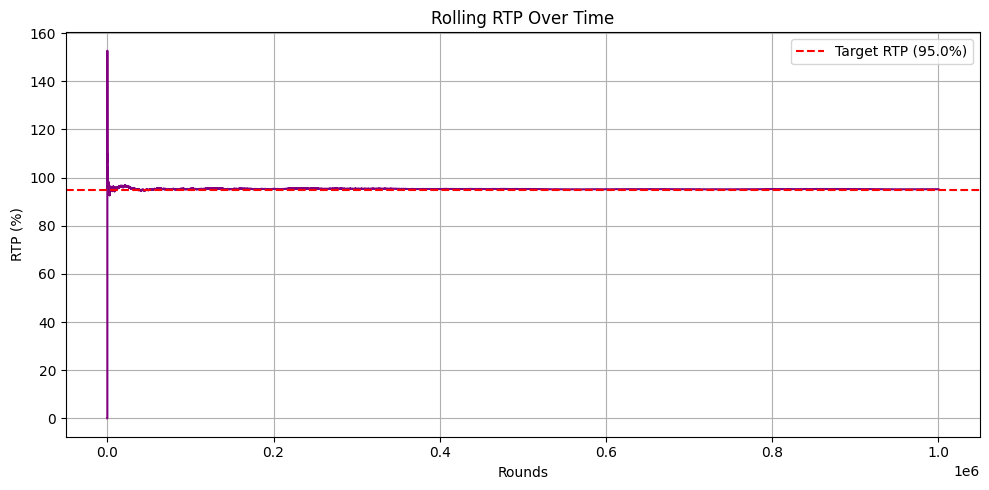

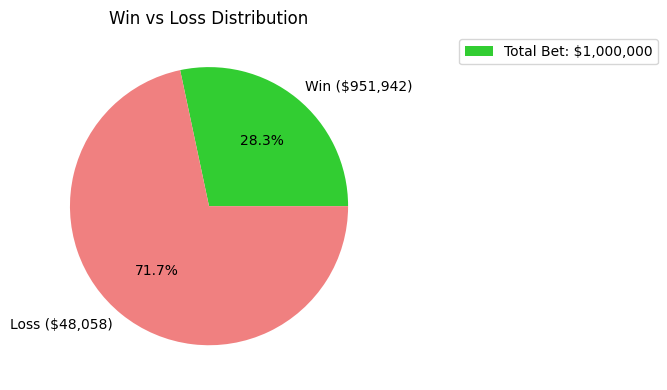

In [37]:
import matplotlib.pyplot as plt

# 1. Distribution of Random Values
plt.figure(figsize=(8, 4))
plt.hist(result_u['rand'], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of Random Values (rand)")
plt.xlabel("Random Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Distribution of Payouts
no_mul, mul = result_u['payout'].unique()
no_mul, mul = float(no_mul), float(mul)

no_mul_count = (result_u['payout'] == no_mul).sum()
mul_count = (result_u['payout'] == mul).sum()

plt.figure(figsize=(6, 4))
plt.pie([mul_count, no_mul_count],
        labels=[f'Win (×{mul})', 'Loss (×0)'],
        autopct='%1.1f%%',
        colors=['dodgerblue', 'gray'])

plt.title("Win vs Loss Multiplier Distribution")
plt.tight_layout()
plt.show()


# 3. Rolling RTP Over Time
result_u['cumulative_payout'] = result_u['payout'].cumsum()
result_u['cumulative_bet'] = result_u['bet'].cumsum()
result_u['rolling_rtp'] = (result_u['cumulative_payout'] / result_u['cumulative_bet']) * 100

plt.figure(figsize=(10, 5))
plt.plot(result_u['rolling_rtp'], color='purple')
plt.axhline(y=target_rtp, color='red', linestyle='--', label=f'Target RTP ({target_rtp}%)')
plt.title("Rolling RTP Over Time")
plt.xlabel("Rounds")
plt.ylabel("RTP (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Win vs Loss Pie Chart
payout_count = (result_u['payout'] > 0).sum()
no_payout_count = (result_u['payout'] == 0).sum()

total_payout = result_u['payout'].sum()
total_bet = result_u['bet'].sum()
total_loss = total_bet - total_payout

plt.figure(figsize=(8, 4))
plt.pie([payout_count, no_payout_count],
        labels=[f'Win (${total_payout:,.0f})', f'Loss (${total_loss:,.0f})'],
        autopct='%1.1f%%',
        colors=['limegreen', 'lightcoral'])

plt.legend([f"Total Bet: ${total_bet:,.0f}"], loc='upper left', bbox_to_anchor=(1.2, 1))
plt.title("Win vs Loss Distribution")
plt.tight_layout()
plt.show()

In [47]:
mul, no_mul = result_o['payout'].unique()
mul, no_mul = float(no_mul), float(mul)
no_mul, mul

(1.42, 0.0)

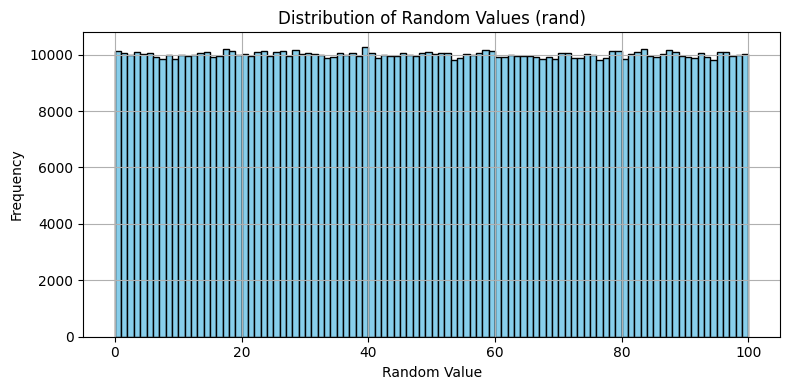

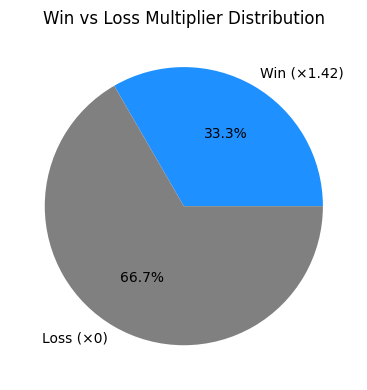

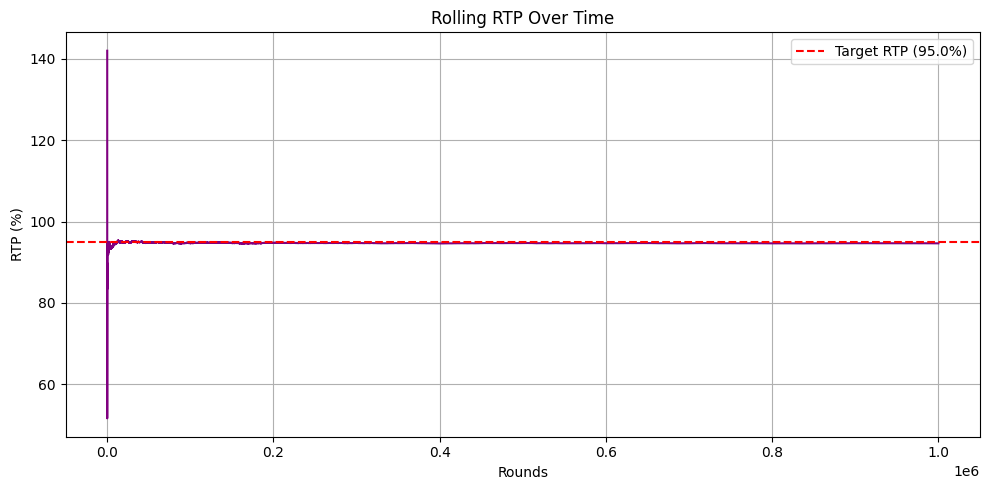

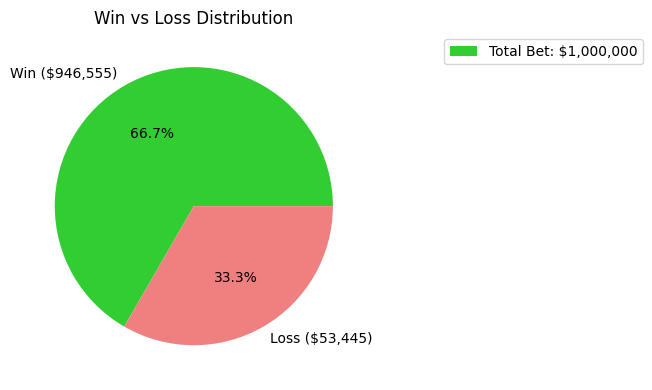

In [49]:
import matplotlib.pyplot as plt

# 1. Distribution of Random Values
plt.figure(figsize=(8, 4))
plt.hist(result_o['rand'], bins=100, color='skyblue', edgecolor='black')
plt.title("Distribution of Random Values (rand)")
plt.xlabel("Random Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Distribution of Payouts
no_mul, mul = result_o['payout'].unique()
no_mul, mul = float(no_mul), float(mul)

no_mul_count = (result_o['payout'] == no_mul).sum()
mul_count = (result_o['payout'] == mul).sum()

plt.figure(figsize=(6, 4))
plt.pie([mul_count, no_mul_count],
        labels=[f'Win (×{no_mul})', 'Loss (×0)'],
        autopct='%1.1f%%',
        colors=['dodgerblue', 'gray'])

plt.title("Win vs Loss Multiplier Distribution")
plt.tight_layout()
plt.show()


# 3. Rolling RTP Over Time
result_o['cumulative_payout'] = result_o['payout'].cumsum()
result_o['cumulative_bet'] = result_o['bet'].cumsum()
result_o['rolling_rtp'] = (result_o['cumulative_payout'] / result_o['cumulative_bet']) * 100

plt.figure(figsize=(10, 5))
plt.plot(result_o['rolling_rtp'], color='purple')
plt.axhline(y=target_rtp, color='red', linestyle='--', label=f'Target RTP ({target_rtp}%)')
plt.title("Rolling RTP Over Time")
plt.xlabel("Rounds")
plt.ylabel("RTP (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 4. Win vs Loss Pie Chart
payout_count = (result_o['payout'] > 0).sum()
no_payout_count = (result_o['payout'] == 0).sum()

total_payout = result_o['payout'].sum()
total_bet = result_o['bet'].sum()
total_loss = total_bet - total_payout

plt.figure(figsize=(8, 4))
plt.pie([payout_count, no_payout_count],
        labels=[f'Win (${total_payout:,.0f})', f'Loss (${total_loss:,.0f})'],
        autopct='%1.1f%%',
        colors=['limegreen', 'lightcoral'])

plt.legend([f"Total Bet: ${total_bet:,.0f}"], loc='upper left', bbox_to_anchor=(1.2, 1))
plt.title("Win vs Loss Distribution")
plt.tight_layout()
plt.show()